In [1]:
!pip install -q -U "monai[nibabel, tqdm]" wandb

In [3]:
import os

import numpy as np
from tqdm.auto import tqdm
import wandb

from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\work\vision\brain-segmentation\.venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INS

In [4]:
wandb.login(key="dbcfb65d2ba6adf8e8738153b4815f4444172d8f")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: muhammadammarzia (muhammadammarzia-iba-institute-of-business-administration). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\muham\_netrc


True

In [5]:
wandb.init(project="monai-brain-scans")

In [6]:
config = wandb.config
config.seed = 0
config.roi_size = [224, 224, 144]
config.batch_size = 1
config.num_workers = 4
config.max_train_images_visualized = 20
config.max_val_images_visualized = 20
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"
config.inference_roi_size = (128, 128, 64)
config.max_prediction_images_visualized = 20

In [7]:
# Make experiment deterministic
set_determinism(seed=config.seed)

# Create directories
os.makedirs(config.dataset_dir, exist_ok=True)
os.makedirs(config.checkpoint_dir, exist_ok=True)

In [8]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [9]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=config.roi_size, random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [10]:
train_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

Saving whole brain images...


100%|██████████| 96/96 [02:13<00:00,  1.39s/it]

Images saved to ./whole_brain_images


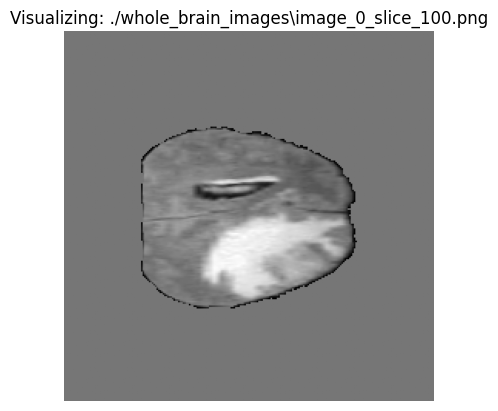

In [11]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, NormalizeIntensityd
from monai.apps import DecathlonDataset

# Directory to save the whole brain images
save_dir = "./whole_brain_images"
os.makedirs(save_dir, exist_ok=True)

# Save images as PNGs
print("Saving whole brain images...")
for idx, sample in enumerate(tqdm(val_dataset)):
    image = sample["image"].detach().cpu().numpy()  # Shape: (C, H, W, D)
    for slice_idx in range(image.shape[-1]):
        slice_image = image[:, :, :, slice_idx]
        slice_path = os.path.join(save_dir, f"image_{idx}_slice_{slice_idx}.png")
        plt.imsave(slice_path, slice_image[0], cmap="gray")  # Save only the first channel

print(f"Images saved to {save_dir}")

# Function to visualize one image from the saved directory
def visualize_image(image_path):
    image = plt.imread(image_path)
    plt.imshow(image, cmap="gray")
    plt.title(f"Visualizing: {image_path}")
    plt.axis("off")
    plt.show()

# Example: Visualize one image
example_image_path = os.path.join(save_dir, "image_0_slice_100.png")
visualize_image(example_image_path)

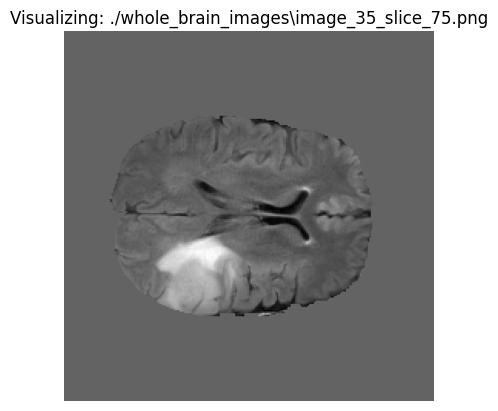

In [12]:
# Example: Visualize one image
example_image_path = os.path.join(save_dir, "image_35_slice_75.png")
visualize_image(example_image_path)

In [15]:
import os
import shutil
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import io

# Directories
input_dir = "./whole_brain_images"  # Directory with saved brain slices
selected_slices_dir = "./selected_slices/brain"
if os.path.exists(selected_slices_dir):
    shutil.rmtree(selected_slices_dir)  # Delete the folder if it exists
os.makedirs(selected_slices_dir)

# Function to extract specific slices
def extract_specific_slices(input_dir, output_dir, slice_start=75, slice_end=80):
    """
    Extract specific slices from a series of brain images.

    Args:
        input_dir (str): Directory containing all slices.
        output_dir (str): Directory to save the selected slices.
        slice_start (int): Starting slice index.
        slice_end (int): Ending slice index (inclusive).
    """
    print("Extracting specific slices...")
    slice_files = sorted(os.listdir(input_dir))
    image_series = {}

    # Group slices by series ID
    for file in slice_files:
        if file.endswith(".png"):
            series_id = file.split("_slice_")[0]  # Group by series ID
            if series_id not in image_series:
                image_series[series_id] = []
            image_series[series_id].append(file)

    # Save slices from slice_start to slice_end for each series
    for series_id, files in tqdm(image_series.items()):
        for file in files:
            slice_idx = int(file.split("_slice_")[1].split(".png")[0])
            if slice_start <= slice_idx <= slice_end:
                src_path = os.path.join(input_dir, file)
                dst_path = os.path.join(output_dir, file)
                shutil.copy(src_path, dst_path)

# Extract slices
extract_specific_slices(input_dir, selected_slices_dir, slice_start=75, slice_end=80)

# Function to visualize one of the selected slices
def visualize_selected_slice(image_path):
    image = io.imread(image_path)
    plt.imshow(image, cmap="gray")
    plt.title(f"Visualizing: {image_path}")
    plt.axis("off")
    plt.show()



Extracting specific slices...


100%|██████████| 96/96 [00:00<00:00, 351.19it/s]


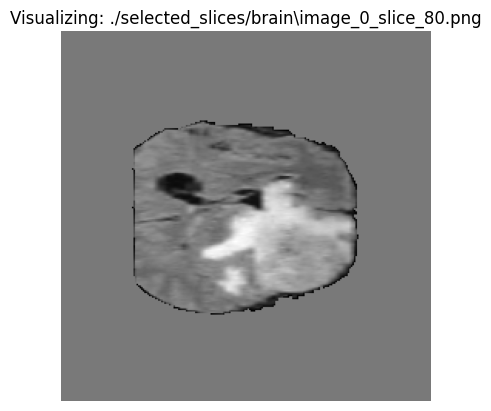

In [16]:
# Example: Visualize one of the selected slices
example_slice = os.path.join(selected_slices_dir, os.listdir(selected_slices_dir)[5])
visualize_selected_slice(example_slice)